In [10]:
import numpy as np

class Activation:
    
    def relu(self, x):
        return np.maximum(x, 0)
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    def tanh(self, x):
        return np.tanh(x)
    def linear(self, x):
        return x
    def softmax(self, x):
        exps = np.exp(x - x.max())
        return exps / np.sum(exps)

    def g_relu(self, x):
        return 1 * (x > 0)
    def g_sigmoid(self, x):
        return (1 - x) * x
    def g_tanh(self, x):
        return 1 - x*x
    def g_linear(self, x):
        return 1 * (x==x)
    def g_softmax(self, x):
        dx_ds = np.diag(x) - np.dot(x, x.T)
        return dx_ds.sum(axis=0).reshape(-1, 1) 

    
    def __init__(self, act):
        funcs = {
            "TANH" : self.tanh,
            "SIGMOID" : self.sigmoid,
            "RELU" : self.relu,
            "LINEAR" : self.linear,
            "SOFTMAX" : self.softmax
        }

        grads = {
            "TANH" : self.g_tanh,
            "SIGMOID" : self.g_sigmoid,
            "RELU" : self.g_relu,
            "LINEAR" : self.g_linear,
            "SOFTMAX" : self.g_softmax
        }
        self.act = act
        self.func = funcs[act]
        self.grad = grads[act]
        
        return       
    
    def __str__(self):
        s = "\nActivation:" + self.act
        return s

In [11]:
import random

class LinearLayer:

    def init_weights(self, num):
        w=[]
        for i in range(num): 
            w.append(random.uniform(-1, 1))
        return w            

    def __init__(self, n_in, n_node, W=None, b=None):
        self.n_node = n_node
        self.n_in = n_in
        
        size = n_in*n_node
        if W == None:
            weights = self.init_weights(size)
            weights = np.array(weights).reshape(n_node, n_in)
            scale = np.sqrt(2./size)
            self.W = weights * scale
        else: 
            nu, ni = W.shape
            if nu != n_node or ni != n_in:
                raise ValueError("Incorrect weights input")
            else:
                self.W = W
              
        self.b = b if b != None else np.zeros(shape=(n_node, 1))

        #self.W = np.ones(shape=(n_node, n_in))
        #self.b = np.ones(shape=(n_node, 1))

        self.x = None
        self.signal = None
        self.y = None

        self.in_grad = None
        self.G = None
        self.g_b = None
        self.out_grad = None
        return
        
    def forward(self, x):
        self.x = x
        self.y = np.dot(self.W, x) + self.b
        self.signal = self.y
        return self.y

    def backward(self, node_grad):       
        self.G = np.outer(node_grad, self.x)
        self.g_b = node_grad
        self.out_grad = np.dot(self.W.T, node_grad)         
        return self.out_grad

    def update(self, learning_rate):
        self.W = self.W - self.G * learning_rate
        self.b = self.b - self.g_b * learning_rate
        return
            
    def __str__(self):
        s = "\nx is:\n"+str(self.x)
        s += "\nW is:\n" + str(self.W)
        s += "\nb is:\n" + str(self.b)
        s += "\ny is:\n"+str(self.y)
        s += "\nin_grad is:\n"+str(self.in_grad)
        s += "\nG is:\n"+str(self.G)
        s += "\ng_b is:\n"+str(self.g_b)
        s += "\nout_grad is:\n"+str(self.out_grad)
        return s
        

In [12]:
class ActivationLayer(LinearLayer):
        
    def __init__(self, n_in, n_node, W=None, b=None, act="SIGMOID"):
        super().__init__(n_in, n_node, W=None, b=None)
        self.activation = Activation(act)
        return
        
    def forward(self, x):
        if x.size != self.n_in: 
            raise ValueError("Incorrect data input", x.size, self.n_in)
        # linear part first
        signal = super().forward(x)
        # nonlinear
        self.y = self.activation.func(signal) 
        return self.y
      
    def backward(self, in_grad):
        if in_grad.size != self.n_node: 
            raise ValueError("Incorrect data input")
        # nonlinear    
        self.in_grad = in_grad
        node_grad = self.activation.grad(self.y)
        node_grad = node_grad * in_grad
        # linear
        self.out_grad = super().backward(node_grad)
        return self.out_grad

    def update(self, learning_rate):
        super().update(learning_rate)
        return

    def __str__(self):
        s = super().__str__()
        s += str(self.activation)
        return s
            

In [13]:
class SoftMaxLayer(ActivationLayer):
        
    def __init__(self, n_in, n_node, W=None, b=None):
        super().__init__(n_in, n_node, W=None, b=None, act="SOFTMAX")
        self.predict = None
        self.truth = None
        return
        
    def forward(self, x):
        # hidden part first, computing softmax
        self.y = super().forward(x)
        self.predict = self.y.argmax()
        return self.predict
      
    def backward(self, in_truth):
        # softmax gradient, dL/ds (combining the cost and activation layer)
        self.truth = np.zeros(self.n_node).reshape(self.n_node,1) 
        self.truth[in_truth] = 1
        node_grad = self.y - self.truth
        # then linear layer
        self.out_grad = LinearLayer.backward(self, node_grad)
        return self.out_grad
    
    def update(self, learning_rate):
        super().update(learning_rate)
        return
    
    def __str__(self):
        s = super().__str__()
        s += "\nPrediction:\n" + str(self.predict)
        s += "\nTruth:\n" + str(self.truth)
        return s
            

In [14]:
import gzip
import struct

import matplotlib as mpl
import matplotlib.pyplot as plt

# pre-requirement: MNIST files from http://yann.lecun.com/exdb/mnist/ stored in local directory
class MnistInput:
    def __init__(self, data):
        if data == "training":
            zX = './train-images-idx3-ubyte.gz'
            zy = './train-labels-idx1-ubyte.gz'
        elif data == "testing":
            zX = './t10k-images-idx3-ubyte.gz'
            zy = './t10k-labels-idx1-ubyte.gz'
        else: raise ValueError("Incorrect data input")
        
        self.zX = zX
        self.zy = zy
        return
    
    def read(self, num):

        zX = self.zX
        zy = self.zy
        with gzip.open(zX) as fX, gzip.open(zy) as fy:
            magic, nX, rows, cols = struct.unpack(">IIII", fX.read(16))
            magic, ny = struct.unpack(">II", fy.read(8))
            if nX != ny: raise ValueError("Inconsistent data and label files")

            img_size = cols*rows
            if num <= 0 or num > nX: num = nX 
            for i in range(num):
                X = struct.unpack("B"*img_size, fX.read(img_size))
                X = np.array(X).reshape(rows, cols)
                y, = struct.unpack("B", fy.read(1))
                yield (X, y)
        return
    


In [15]:
from IPython.core.debugger import set_trace
class MNIST:

    def __init__(self, n_in=28*28, n_node=28*28+1, n_class=10, learning_rate=0.1):   
        self.train_input = MnistInput("training")
        self.test_input = MnistInput("testing")
        self.n_in = n_in
        self.n_node = n_node if (n_node != None) else (n_in+ 1)
        self.hidden_layer1 = ActivationLayer(n_in, n_node)
        #self.hidden_layer2 = ActivationLayer(n_node, n_node)
        self.output_layer = SoftMaxLayer(n_node, n_class)
        
        self.learning_rate = learning_rate
        return
    
    def forward(self, x):
        y = self.hidden_layer1.forward(x)
        #y = self.hidden_layer2.forward(y)
        self.output_layer.forward(y)
        return
    
    def backward(self, label):
        out_grad = self.output_layer.backward(label)
        #out_grad = self.hidden_layer2.backward(out_grad)
        self.hidden_layer1.backward(out_grad)
        return
    
    def update(self):
        self.hidden_layer1.update(self.learning_rate)
        #self.hidden_layer2.update(self.learning_rate)
        self.output_layer.update(self.learning_rate)
        return
        
    def train_1sample(self, x, label):
        self.forward(x)
        self.backward(label)
        self.update()
        return

    def train(self, n_sample):
        for X, y in self.train_input.read(n_sample):
            self.train_1sample(X.reshape(-1,1)/255, y)
        return
    
    def predict_1sample(self, x):
        y = self.hidden_layer1.forward(x)
        #y = self.hidden_layer2.forward(y)
        predict = self.output_layer.forward(y)
        return predict
        
    def test(self, n_sample):
        correct = 0
        total = 0
        for X, y in self.test_input.read(n_sample):
            predict = self.predict_1sample(X.reshape(-1,1)/255)
            correct += 1 * (predict == y)
            total += 1
            #print("\nPredict:", predict)
            #plt.imshow(X, cmap=mpl.cm.Greys)
            #plt.show()
        accuracy = correct/total
        return accuracy

In [16]:
mnist = MNIST(3,4,3)
X = [
    [1,2,3],
    [2,1,3],
    [3,1,2],
    [3,2,1],
    [1,3,2],
    [2,3,1]
    ]
Y = [2,2,0,0,1,1]
X = np.array(X)
Y = np.array(Y)

for j in range(40):
    for i in range(X.shape[0]):
        mnist.train_1sample(X[i].reshape(-1,1), Y[i])

X = np.array([[1,2,3],[2,3,1],[3,1,2]])
for i in range(X.shape[0]):
    predict = mnist.predict_1sample(X[i].reshape(-1,1))
    print("\nPredict: ", X[i], predict)



Predict:  [1 2 3] 2

Predict:  [2 3 1] 1

Predict:  [3 1 2] 0


In [19]:

mnist = MNIST()
for i in range(5):
    mnist.train(-1)
    accuracy = mnist.test(-1)
    print("\nAccuracy of epoch {} is {}".format(i, accuracy))



Accuracy of epoch 0 is 0.9525

Accuracy of epoch 1 is 0.9585

Accuracy of epoch 2 is 0.9632

Accuracy of epoch 3 is 0.9647

Accuracy of epoch 4 is 0.9668



Predict:  7


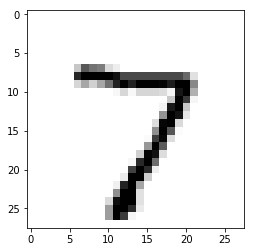


Predict:  2


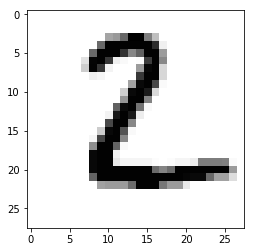


Predict:  1


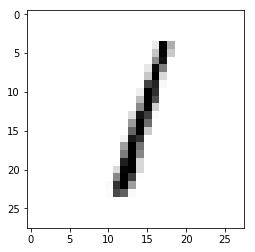


Predict:  0


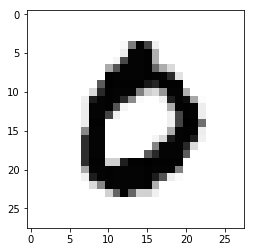


Predict:  4


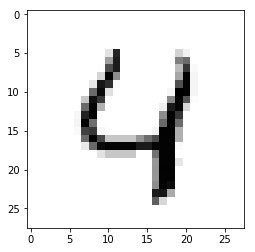


Predict:  1


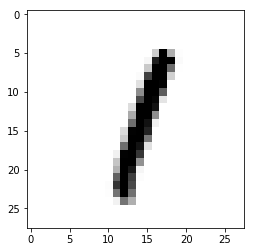


Predict:  4


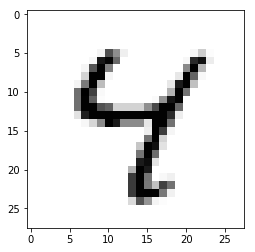


Predict:  9


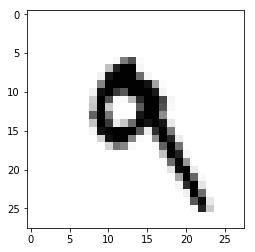


Predict:  5


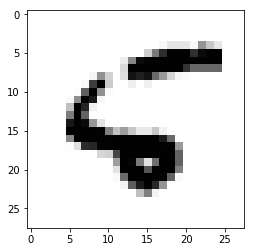


Predict:  9


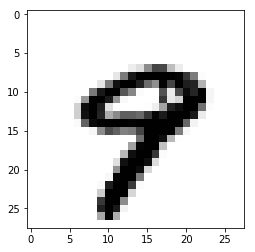

In [20]:
for X, y in mnist.test_input.read(10):
    predict = mnist.predict_1sample(X.reshape(-1,1)/255)
    print("\nPredict: ", predict)
    plt.imshow(X, cmap=mpl.cm.Greys)
    plt.show()